In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# hep.style.use(hep.style.ROOT)

# Classifiaction of Single Muon Tracks with `scikit-learn` `MLPClassifier`

In [2]:
def add_labels(z: float)->int:
    if -800.0 < z and z < -500.0:
        return 0
    if -500.0 < z and z < -305.0:
        return 1
    if -305.0 < z and z < -295.0:
        return 2
    if -295.0 < z and z < 0.0:
        return 3
    if 0.0 < z and z < 300.0:
        return 4
    else:
        return -99

In [3]:
df = pd.read_csv('events-200k.csv')
df['hot_id']  = df['vtz'].apply(add_labels)

In [4]:
# split train and target
X, y = df[['q1', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'px1', 'py1', 'pz1', 'px2', 'py2', 'pz2']].to_numpy(),\
             df[['vtx', 'vty', 'vtz', 'vpx', 'vpy', 'vpz','hot_id']].to_numpy()

In [5]:
# one hot encoding
ohe = OneHotEncoder(sparse=False)
y_hotid = ohe.fit_transform(y[:, 6].reshape(-1, 1))
y = np.concatenate((y[:, :6], y_hotid), axis=1)
print(ohe.categories_)

[array([0., 1., 2., 3., 4.])]


In [6]:
# train, validate test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.25)

In [7]:
# scale the train, validate and test inputs
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [8]:
"""
Classification using sklearn MLPClassifier
info https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
"""

clf = MLPClassifier(max_iter=300, hidden_layer_sizes=(64, 64, 64), batch_size=64)
clf.fit(X_train, y_train[:, 6:])
score = clf.score(X_test, y_test[:, 6:])
print("classification score = {}".format(score))

classification score = 0.9907881519954921


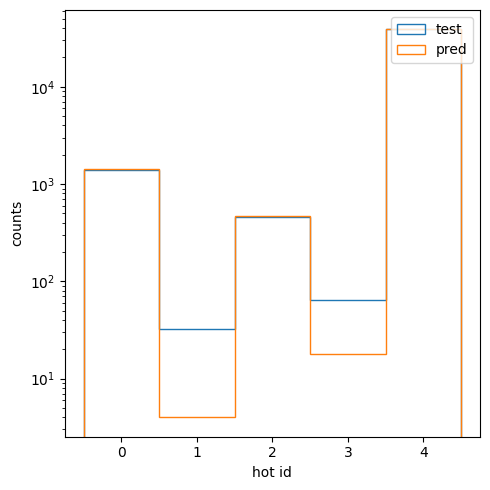

In [9]:
y_pred_hotid = clf.predict(X_test)
y_pred_deco = np.argmax(y_pred_hotid, axis=1)
y_test_deco = np.argmax(y_test[:, 6:], axis=1)

# print("size y_test = {}".format(y_test_deco.shape))
# print("size y_pred = {}".format(y_pred_deco.shape))

plt.figure(figsize=(5, 5))
plt.hist(y_test_deco, histtype='step', bins=5, range=(-0.5, 4.5), label='test')
plt.hist(y_pred_deco, histtype='step', bins=5, range=(-0.5, 4.5), label='pred')
plt.xlabel('hot id')
plt.ylabel('counts')
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.savefig('imgs/cls-hot-id.png')
plt.show()

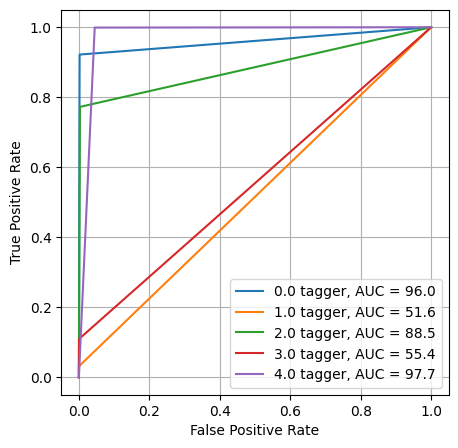

In [10]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_test, y_pred, labels):
    for x in range(5):        
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        plt.plot(fpr, tpr, label='{0} tagger, AUC = {1:.1f}'.format(labels[0][x], auc(fpr, tpr)*100.), linestyle='-')
    # plt.semilogy()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    # plt.ylim(0.001, 1)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.savefig('imgs/roc-curve.png')
    
plt.figure(figsize=(5, 5))
plot_roc(y_test[:, 6:], y_pred_hotid, ohe.categories_)

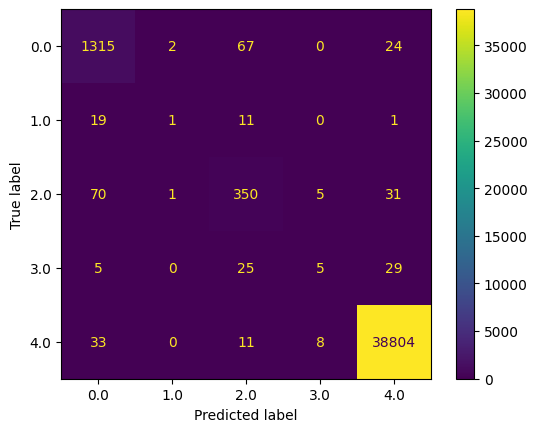

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test_deco, y_pred_deco, labels=ohe.categories_[0])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ohe.categories_[0])
disp.plot()
plt.savefig('imgs/cm.png')
plt.show()

In [12]:
y_train_hotid = clf.predict(X_train)
X_train_hotid = np.concatenate((X_train, y_train_hotid), axis=1)
# X_train_hotid

In [13]:
from sklearn.neural_network import MLPRegressor

reg = MLPRegressor(max_iter=500, hidden_layer_sizes=(64, 64, 64), batch_size=64)
reg.fit(X_train_hotid, y_train[:, :6])

X_test_hotid = np.concatenate((X_test, y_pred_hotid), axis=1)

y_pos_pred = reg.predict(X_test_hotid)

score = reg.score(X_test_hotid, y_test[:, :6])

print("regression score : {}".format(score))

regression score : 0.6196012946401838


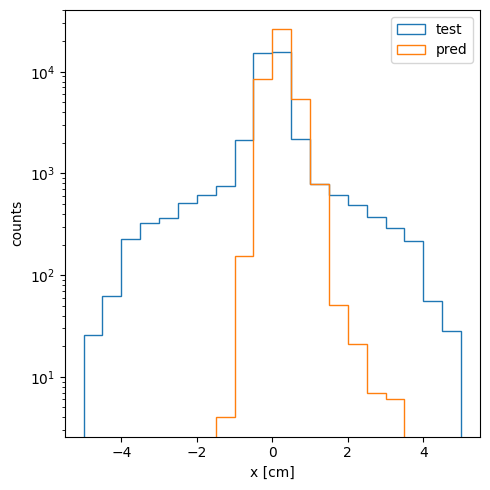

In [14]:
plt.figure(figsize=(5, 5))
plt.hist(y_test[:, 0], histtype='step', label='test', bins=20, range=[-5., 5.])
plt.hist(y_pos_pred[:, 0], histtype='step', label='pred', bins=20, range=[-5., 5.])
plt.yscale('log')
plt.xlabel('x [cm]')
plt.ylabel('counts')
plt.legend()
plt.tight_layout()
plt.savefig('imgs/cls-vtx.png')
plt.show()

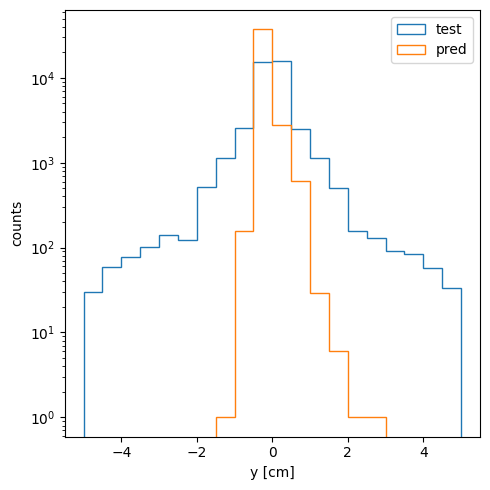

In [15]:
plt.figure(figsize=(5, 5))
plt.hist(y_test[:, 1], histtype='step', label='test', bins=20, range=[-5., 5.])
plt.hist(y_pos_pred[:, 1], histtype='step', label='pred', bins=20, range=[-5., 5.])
plt.yscale('log')
plt.xlabel('y [cm]')
plt.ylabel('counts')
plt.legend()
plt.tight_layout()
plt.savefig('imgs/cls-vty.png')
plt.show()

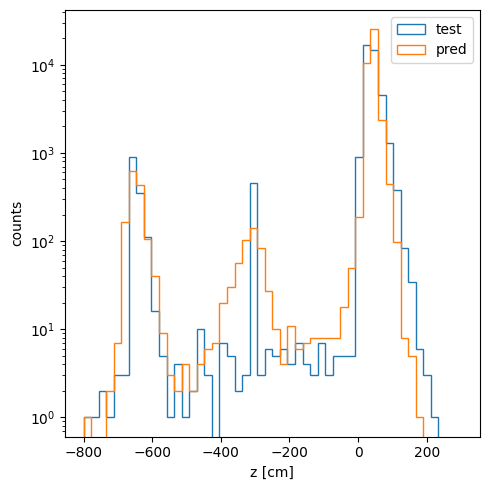

In [16]:
plt.figure(figsize=(5, 5))
plt.hist(y_test[:, 2], histtype='step', label='test', bins=50, range=[-800., 300.])
plt.hist(y_pos_pred[:, 2], histtype='step', label='pred', bins=50, range=[-800., 300.])
plt.yscale('log')
plt.xlabel('z [cm]')
plt.ylabel('counts')
plt.legend()
plt.tight_layout()
plt.savefig('imgs/cls-vtz.png')
plt.show()

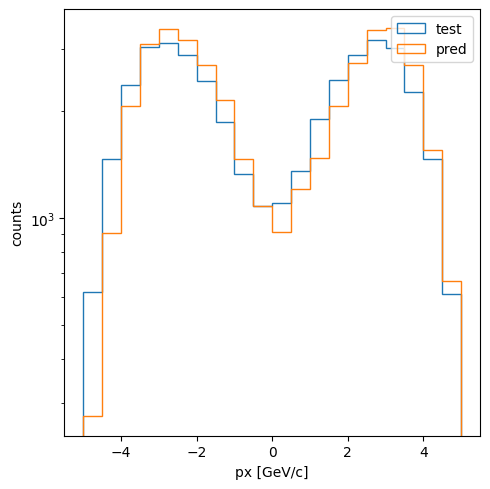

In [17]:
plt.figure(figsize=(5, 5))
plt.hist(y_test[:, 3], histtype='step', label='test', bins=20, range=[-5., 5.])
plt.hist(y_pos_pred[:, 3], histtype='step', label='pred', bins=20, range=[-5., 5.])
plt.yscale('log')
plt.xlabel('px [GeV/c]')
plt.ylabel('counts')
plt.legend()
plt.tight_layout()
plt.savefig('imgs/cls-vpx.png')
plt.show()

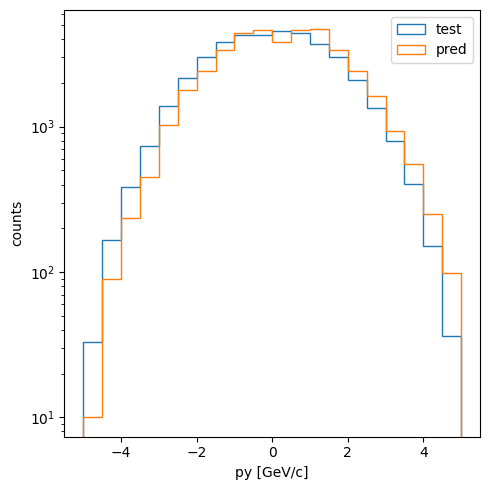

In [18]:
plt.figure(figsize=(5, 5))
plt.hist(y_test[:, 4], histtype='step', label='test', bins=20, range=[-5., 5.])
plt.hist(y_pos_pred[:, 4], histtype='step', label='pred', bins=20, range=[-5., 5.])
plt.yscale('log')
plt.xlabel('py [GeV/c]')
plt.ylabel('counts')
plt.legend()
plt.tight_layout()
plt.savefig('imgs/cls-vpy.png')
plt.show()

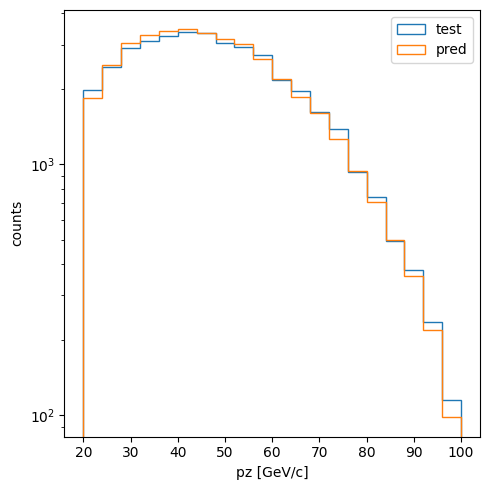

In [19]:
plt.figure(figsize=(5, 5))
plt.hist(y_test[:, 5], histtype='step', label='test', bins=20, range=[20., 100.])
plt.hist(y_pos_pred[:, 5], histtype='step', label='pred', bins=20, range=[20., 100.])
plt.yscale('log')
plt.xlabel('pz [GeV/c]')
plt.ylabel('counts')
plt.legend()
plt.tight_layout()
plt.savefig('imgs/cls-vpz.png')
plt.show()